In [1]:
# !mkdir -p data
# !wget -O data/train.tar https://people.eecs.berkeley.edu/~hendrycks/streethazards_train.tar
# !wget -O data/test.tar https://people.eecs.berkeley.edu/~hendrycks/streethazards_test.tar
# !tar -xf data/train.tar -C data
# !tar -xf data/test.tar -C data

In [2]:
%load_ext autoreload
%autoreload 2

import os
import json
from pathlib import Path
from typing import Optional

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms

from utils.street_hazards import StreetHazardsDataset, StreetHazardsClasses, visualize_scene, visualize_annotation
from utils.misc import set_random_seeds

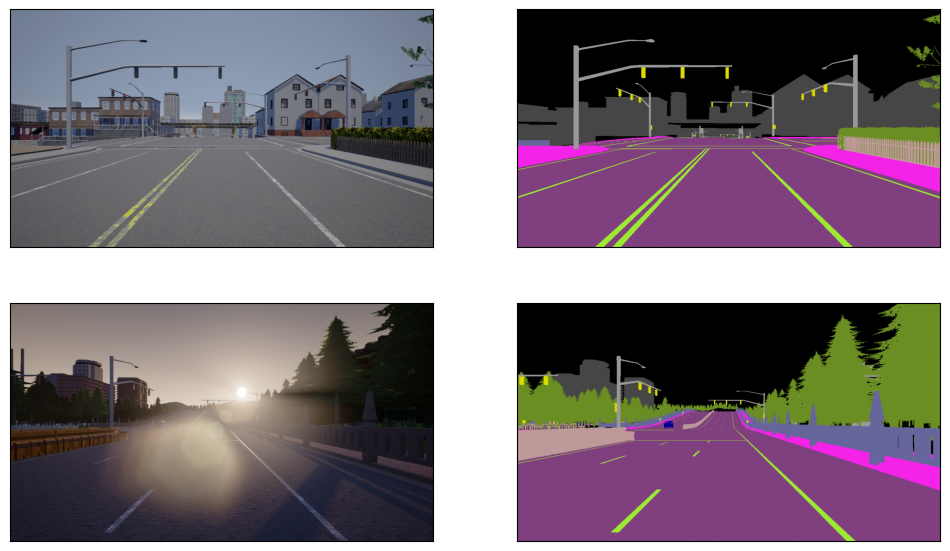

In [3]:
ds_train = StreetHazardsDataset("./data/train/train.odgt")
ds_val = StreetHazardsDataset("./data/train/validation.odgt")

plt.figure(figsize=(12, 7))
plt.subplot(2, 2, 1)
visualize_scene(ds_train[0][0])
plt.subplot(2, 2, 2)
visualize_annotation(ds_train[0][1])
plt.subplot(2, 2, 3)
visualize_scene(ds_val[0][0])
plt.subplot(2, 2, 4)
visualize_annotation(ds_val[0][1])
plt.show()